In [1]:
!pipenv install sentence_transformers
!pipenv install umap-learn
!pipenv install hdbscan
!pipenv install joblib==1.1.0

Installing sentence_transformers...
Adding sentence_transformers to Pipfile's [packages]...
✔ Installation Succeeded 
Installing dependencies from Pipfile.lock (e17d89)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00
Installing umap-learn...
Adding umap-learn to Pipfile's [packages]...
✔ Installation Succeeded 
Installing dependencies from Pipfile.lock (e17d89)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00
Usage: pipenv [OPTIONS] COMMAND [ARGS]...
Try 'pipenv -h' for help.

Error: No such option: --quietinstall Did you mean --quiet?
Installing joblib==1.1.0...
Adding joblib to Pipfile's [packages]...
✔ Installation Succeeded 
Installing dependencies from Pipfile.lock (e17d89)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00


### Imports

In [14]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
# from tqdm import tqdm
# import plotly.graph_objects as go
import plotly.express as px

# Topic modeling
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.feature_extraction.text import TfidfVectorizer
from umap import UMAP
# from sklearn.cluster import KMeans
from hdbscan import HDBSCAN

LANG = 'Portuguese'

### Load data

In [15]:
data = pd.read_csv("../data/processed/tweets.csv")
# Filter tweets in Spanish
data = data.loc[data['Language'] == 'pt']
data.head()

,Text,Classification,Language,Label
1169,@Paollabrasil1 @CarlosBolsonaro Ele votou cont...,sim,pt,1
1170,@LiaBolsonaro @eusoupetersen @CarlosBolsonaro ...,sim,pt,1
1171,@martaserrat @jairbolsonaro @BolsonaroSP @Cris...,sim,pt,1
1172,@EntreOutrasMil @CarlosBolsonaro Gostosa e bur...,sim,pt,1
1173,@inesbalbino25 @CarlosBolsonaro Menina de deus...,sim,pt,1


### Process data

In [16]:
# Function to automate data cleasing
def regex_transforms(x):

  # Replace multiple symbols
  re_1 = re.sub("[^\w\d\s]{2,}", "", x)

  # Replace strings beginning with @
  re_2 = re.sub("@[\w]+", "", re_1)

  # Replace links
  re_3 = re.sub("http.+\s", "", re_2)

  # Replace "RT" token
  re_4 = re.sub("(?i)RT\s", "", re_3)

  # Replace numbers
  re_5 = re.sub("[\d]", "", re_4)

  # Replace whitespaces at the end
  re_6 = re.sub("\s?[\W]\s", " ", re_5)

  return re_6

def remove_sp_chars(x):
  pr_1 = x.translate(str.maketrans(""""~-_\&%#|""", 
                                   "         ")).split()
  pr_2 = " ".join(pr_1)

  return pr_2

# Apply function to data 
data["Text_Processed"] = data["Text"].apply(regex_transforms)
data["Text_Processed"] = data["Text_Processed"].apply(remove_sp_chars)

# Show data
data.head()

,Text,Classification,Language,Label,Text_Processed
1169,@Paollabrasil1 @CarlosBolsonaro Ele votou cont...,sim,pt,1,Ele votou contra o fundão que o bolsomico quer...
1170,@LiaBolsonaro @eusoupetersen @CarlosBolsonaro ...,sim,pt,1,Voce é burra ou é só má fé?
1171,@martaserrat @jairbolsonaro @BolsonaroSP @Cris...,sim,pt,1,Mas os canalhas pegaram no pé dele mesmo É rid...
1172,@EntreOutrasMil @CarlosBolsonaro Gostosa e bur...,sim,pt,1,Gostosa e burra perfeitinha
1173,@inesbalbino25 @CarlosBolsonaro Menina de deus...,sim,pt,1,Menina de deus o que que tu tá fumando Você tá...


### Embeddings

In [17]:
# Import algorithm to generate embeddings
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


In [18]:
# Filter data cassified as hate speech
subset_hs = data[data["Label"] == 1]

# Process data with encoder
vecs = sbert_model.encode(subset_hs["Text_Processed"].values)


In [19]:
# Apply the dimensionality reduction process.

# Scaler to normalize data
scaler = StandardScaler()
# PCA to reduce multicollinearity and noise
pca_ = PCA(0.9, random_state=5)
# UMAP to reduce dimensionality to two components
umap_ = UMAP(n_components=2,
             random_state=5,
             metric="cosine",
             n_neighbors=50,
             min_dist=0.1)

vecs_sc = scaler.fit_transform(vecs)
vecs_pca = pca_.fit_transform(vecs_sc)
vecs_umap = umap_.fit_transform(vecs_pca)


In [20]:
# Assign components to dataset
subset_hs.loc[:,"COMP_1"] = vecs_umap[:,0]
subset_hs.loc[:,"COMP_2"] = vecs_umap[:,1]

# Show data
subset_hs.head()

/tmp/ipykernel_48853/303276436.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_48853/303276436.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Text,Classification,Language,Label,Text_Processed,COMP_1,COMP_2
1169,@Paollabrasil1 @CarlosBolsonaro Ele votou cont...,sim,pt,1,Ele votou contra o fundão que o bolsomico quer...,8.145769,5.025225
1170,@LiaBolsonaro @eusoupetersen @CarlosBolsonaro ...,sim,pt,1,Voce é burra ou é só má fé?,5.978381,7.721466
1171,@martaserrat @jairbolsonaro @BolsonaroSP @Cris...,sim,pt,1,Mas os canalhas pegaram no pé dele mesmo É rid...,9.413983,2.585227
1172,@EntreOutrasMil @CarlosBolsonaro Gostosa e bur...,sim,pt,1,Gostosa e burra perfeitinha,6.259656,8.087798
1173,@inesbalbino25 @CarlosBolsonaro Menina de deus...,sim,pt,1,Menina de deus o que que tu tá fumando Você tá...,6.622025,7.321076


In [21]:
# Visualize the distribution of embeddings with a hover to see the tweets.
fig = px.scatter(
    subset_hs,
    x="COMP_1",
    y="COMP_2",
    hover_data=["Text_Processed"])
fig.show()

### Clustering

In [42]:
# Apply the HDBSCAN algorithm to extract the clusters.

mc_size = 10
m_samples = 5

db_model = HDBSCAN(min_cluster_size=mc_size,
                   min_samples=m_samples,
                   metric="euclidean", 
                   )
db_model.fit(subset_hs.loc[:,["COMP_1", "COMP_2"]])
subset_hs.loc[:, "CLUSTER"] = db_model.labels_
subset_hs.loc[:, "PROBA"] = db_model.probabilities_

/tmp/ipykernel_48853/28679132.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_48853/28679132.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



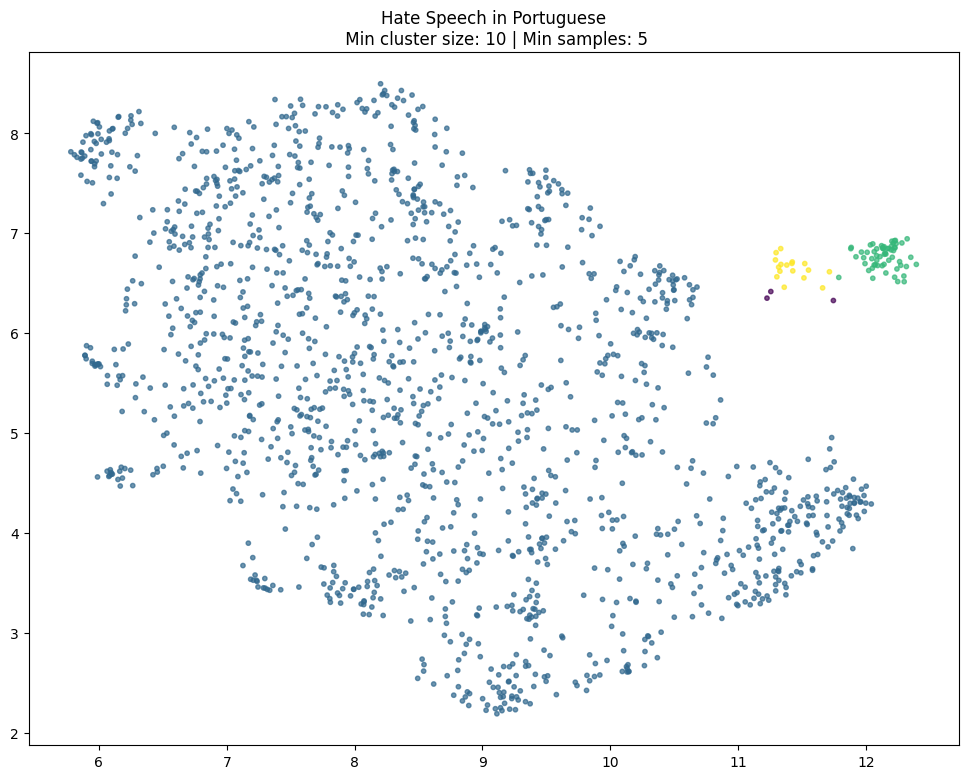

In [43]:
# Visualize clusters
plt.figure(figsize=(12,9))
plt.scatter(vecs_umap[:,0], vecs_umap[:,1], alpha=0.7, c=db_model.labels_, s=10)
plt.title(f"Hate Speech in {LANG}\n Min cluster size: {mc_size} | Min samples: {m_samples}")
plt.show()

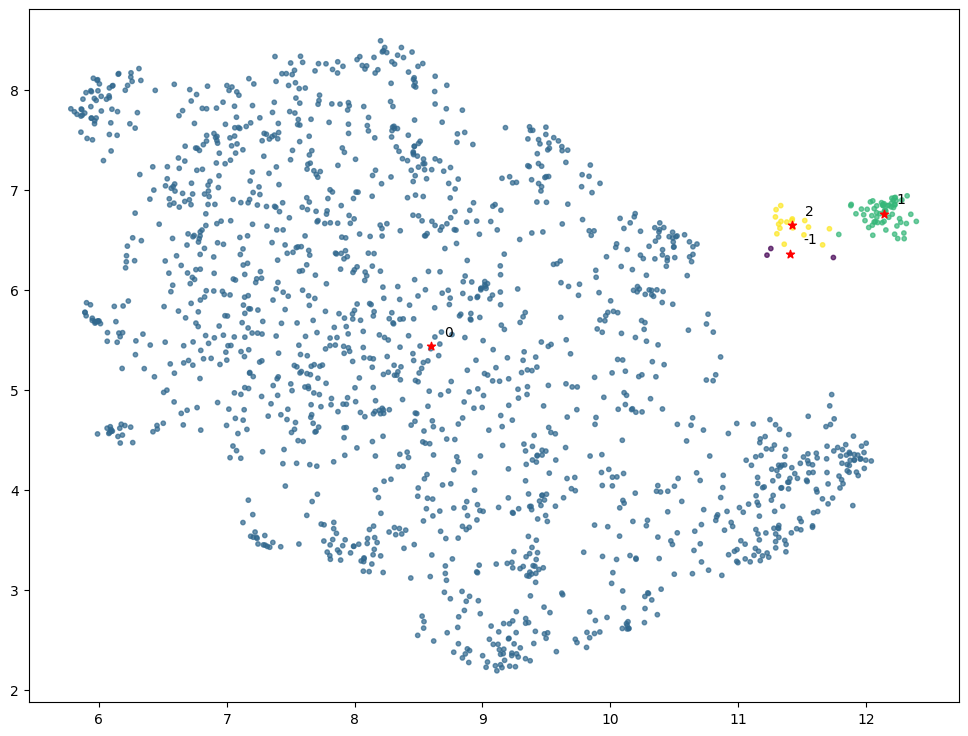

In [44]:
# Extract the centroid of each cluster

cl_centroids = {}

for i in sorted(subset_hs["CLUSTER"].unique()):

  cl_centroids[i] = subset_hs[subset_hs["CLUSTER"] == i][["COMP_1", "COMP_2"]].mean().values

centroids_array = np.array(list(cl_centroids.values()))

fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(vecs_umap[:,0], vecs_umap[:,1], s=10, alpha=0.7, c=db_model.labels_)
ax.scatter(centroids_array[:,0], centroids_array[:,1], marker="*", c="red")
for i in cl_centroids:
  ax.annotate(i, cl_centroids.get(i)+np.array([0.1, 0.1]))
plt.show()


In [45]:

from sklearn.metrics.pairwise import euclidean_distances

N = 5

for i in cl_centroids:
  point = cl_centroids.get(i).reshape(1,-1)
  ix_min_dist = np.argsort(euclidean_distances(point, subset_hs.loc[:, ["COMP_1", "COMP_2"]])).flatten()[:N]
  print(f"Tweets más representativos del cluster {i}")
  print(subset_hs.iloc[ix_min_dist, 
                       subset_hs.columns.get_loc("Text_Processed")].values, "\n")


Tweets más representativos del cluster -1
['Como jornalista você é muito mal informada,da dó assistir sua decadência,verifica dados corretos e não fake simularam muito mal feito uma pessoa gritando que nem lá estava talvez em um quarto fechado de vergonha e deixaram o áudio do local no mudo,o áudio verdadeiro é top demais'
 'E isso que acabou Índia fake Acabou a mamata BolsonaroReeleito httpst.co/lfniddu'
 'Isso não é jornalismo É uma mentira deslavada Se vc utiliza e divulga um video fake para promoção isso tem outro nome E com certeza passa bem longe do jornalista Compreensível é o fato de agregar uma m ao nome.'
 'Não temos culpa se você é surda também Cega já sabemos que você é O vídeo fake já foi desmentido mas você como pseudo jornalista não sabe.'
 'Aquilo ali foi invenção de uma jornalista da Colômbia tanto que depois ela disse q era o Santos do México só pra n admitir que era fake'] 

Tweets más representativos del cluster 0
['Desde quando índio apoia comunistas ditadores Essa